# 05-Error Metrics

_[Estimated execution time: 15 min]_

The toolkit allows to evaluate standard error metrics automatically. This notebook will continue the air quality data set used in the previous tutorial [04-Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb).

In [1]:
import mogptk
import numpy as np
import pandas as pd

# Air Quality MOGP

For this tutorial we will use the air quality dataset. The data set contains hourly averaged responses from an array of five metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located in the field in a significantly polluted area in an Italian city. Data were recorded for one year from March 2004 representing the longest freely available recordings of a deployed air quality chemical sensor device.

We will only use five columns: CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT). For more information on data loading check out the tutorial [01 Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb). For more information on data handling check out the tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

For each sensor the minimum value is -200, which is also the default value when there is an error in the measurements. We will ignore them by converting them to `NaN`.

In [2]:
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

# Replace missing values with NaN
df.replace(-200.0, np.nan, inplace=True)

# First two columns are date and time
# We convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Define an initial date to compare all other to it
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# Get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# Use only the first eight days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
dataset = mogptk.LoadDataFrame(df2, x_col='Time', y_col=cols)

Remove aditional data to simulate sensor failure. In this case for each channel we will first remove 50% of the observations and then remove complete sectors in order to get reconstructions from the other channels through learned cross correlations.

We will also use data transformation as defined in the data preparation and transformation tutorial [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb) where each channel is normalized so it has zero mean and unit variance.

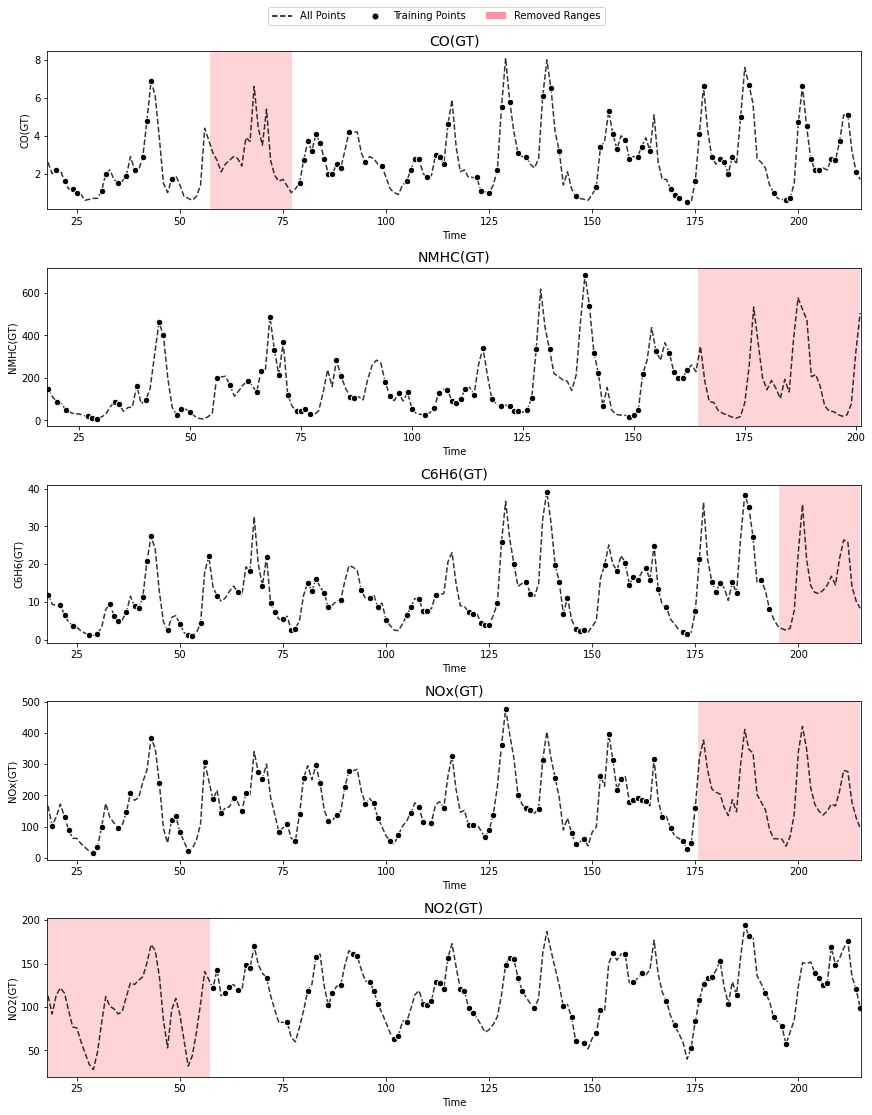

In [3]:
for channel in dataset:
    channel.remove_randomly(pct=0.5)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, 1.0)
dataset[2].remove_relative_range(0.9, 1.0)
dataset[3].remove_relative_range(0.8, 1.0)
dataset[4].remove_relative_range(0.0, 0.2)

for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))
    channel.transform(mogptk.TransformWhiten())
dataset.plot();

Then we create the test inputs and outputs by calling `Data.get_test_data()`.

In [4]:
x_test, y_test = dataset.get_test_data()

# Models

We will use one of each of the models in the toolkit, starting with independent Gaussian processes with an [SM](https://games-uchile.github.io/mogptk/sm.html) kernel.

## Independent channels with spectral mixture kernels

For each channel we will use Q=4

In [5]:
Q = 4  # number of mixtures
sm = mogptk.SM(dataset, Q=Q)
sm.init_parameters('BNSE')
sm.train(method='Adam', lr=0.5, iters=500, verbose=True)


Starting optimization using Adam
‣ Model: SM
‣ Channels: 5
‣ Mixtures: 4
‣ Training points: 402
‣ Parameters: 65
‣ Initial NLL: 1.481

Optimization finished in 0.34 minutes
‣ Function evaluations: 500
‣ Final NLL: 1.026


### Evaluating errors

Using the [`mogptk.test_errors`](https://games-uchile.github.io/mogptk/errors.html#mogptk.errors.test_errors) function given a test input and output it calculates:

* Mean absolute error (MAE)
* Normalized mean absolute error (nMAE)
* Root mean squared error (RMSE)
* Normalized mean absolute squared error (nRMSE)

If only the raw values $y_{true} - y_{pred}$ are desired, the flag `simple` must be passed.

Multiple models for the same test set (X, Y) can be passed at once, the result will be a list with one element for each model passed, where each element is another list of length equal to the number or channels where each element is the error for said model and channel. This enables to obtain errors for multiple models for the same test set where each channel can have different numbers of test points.

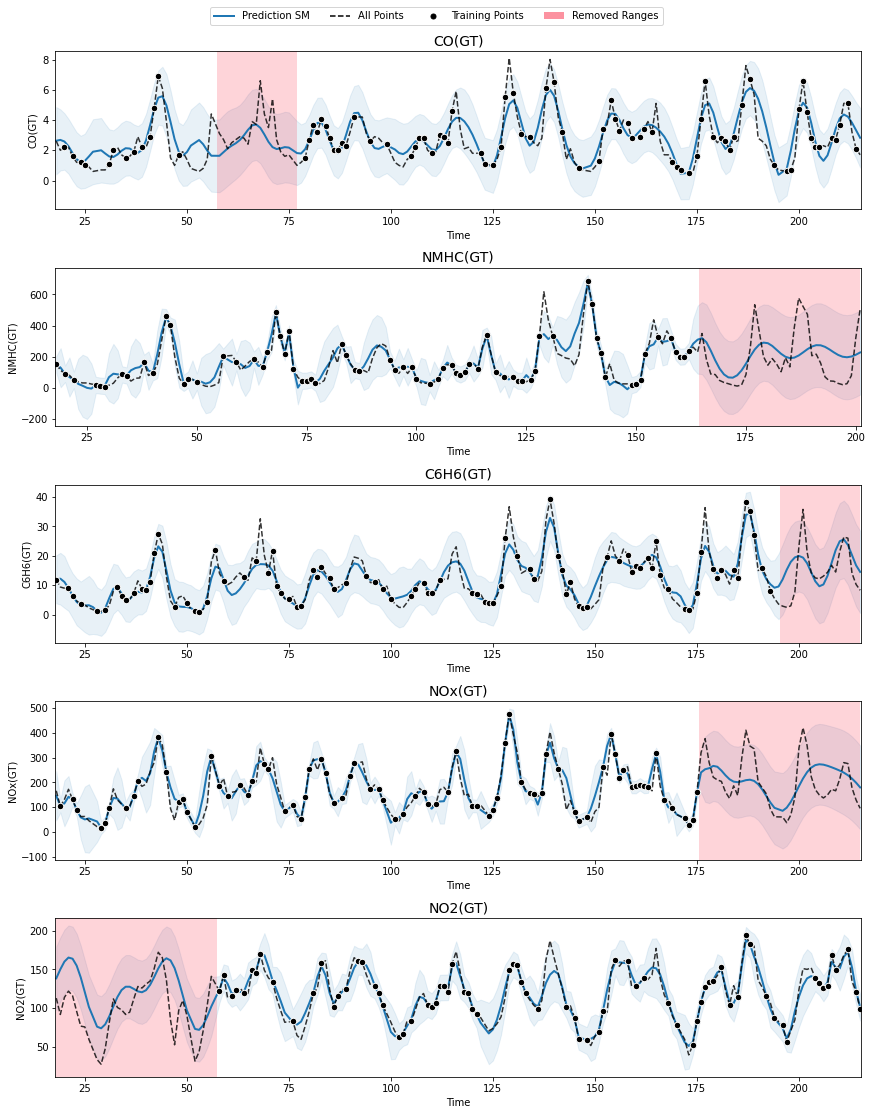

In [6]:
sm.predict()
dataset.plot();

In [7]:
mogptk.errors_at(sm, X=x_test, Y=y_test, disp=True)

,MAE,nMAE,RMSE,nRMSE,MAPE
Name,,,,,
SM channel 0,0.874847,0.115111,1.135842,0.149453,48.195426816851636
SM channel 1,76.579401,0.125335,105.843300,0.173230,104.65148058028018
SM channel 2,3.371040,0.094692,4.782753,0.134347,46.4864195344586
SM channel 3,49.205935,0.123015,65.356623,0.163392,35.197313482049026
SM channel 4,16.971242,0.106737,24.085066,0.151478,20.36849543214299


## Multi Output Spectral Mixture (MOSM)

Next we use the multi output spectral mixture kernel (Parra et al, 2016).


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 5
‣ Mixtures: 4
‣ Training points: 402
‣ Parameters: 120
‣ Initial NLL: 1.048

Optimization finished in 1.31 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.351


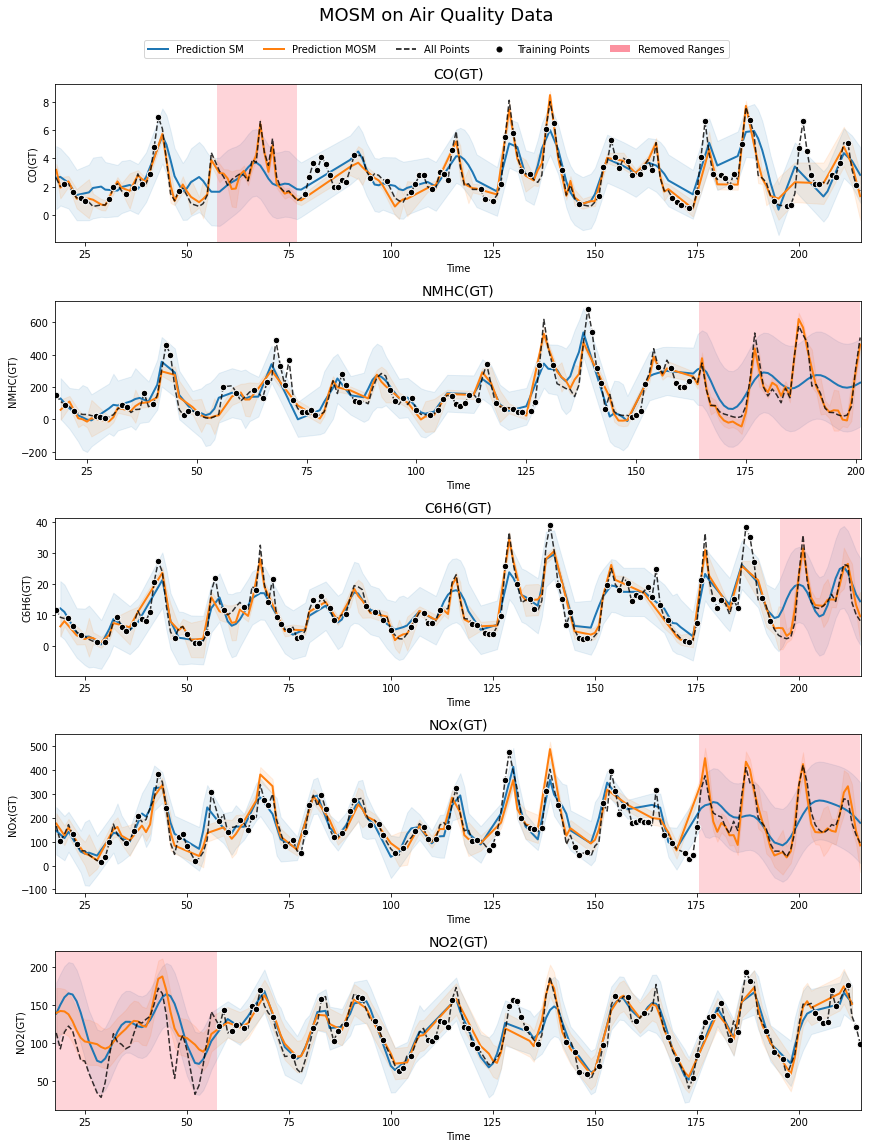

In [8]:
mosm = mogptk.MOSM(dataset, Q=4)
mosm.init_parameters('BNSE')
mosm.train(method='Adam', iters=500, lr=0.5, verbose=True)

mosm.predict()
dataset.plot(title='MOSM on Air Quality Data');

## Cross Spectral Mixture (CSM)

Then we use the cross spectral mixture kernel (Ulrich et al, 2015).


Starting optimization using Adam
‣ Model: CSM
‣ Channels: 5
‣ Mixtures: 4
‣ Training points: 402
‣ Parameters: 68
‣ Initial NLL: 1.005

Optimization finished in 1.00 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.516


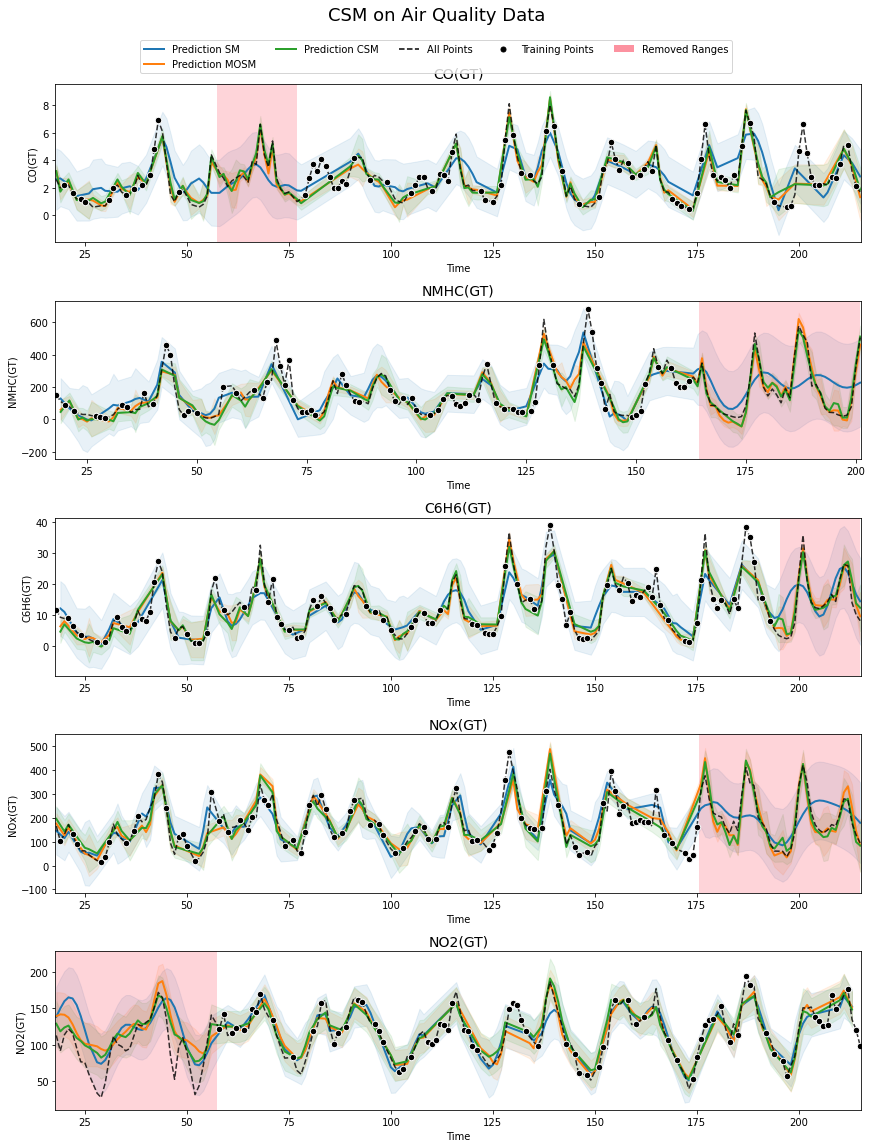

In [9]:
csm = mogptk.CSM(dataset, Q=4)
csm.init_parameters()
csm.train(method='Adam', iters=500, lr=0.5, verbose=True)

csm.predict()
dataset.plot(title='CSM on Air Quality Data');

## Spectral Mixture - Linear Model of Corregionalization (SM-LMC)

Lastly we fit the spectral mixture linear model of corregionalization (Wilson, 2014).


Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 5
‣ Mixtures: 4
‣ Training points: 402
‣ Parameters: 33
‣ Initial NLL: 0.962

Optimization finished in 0.58 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.498


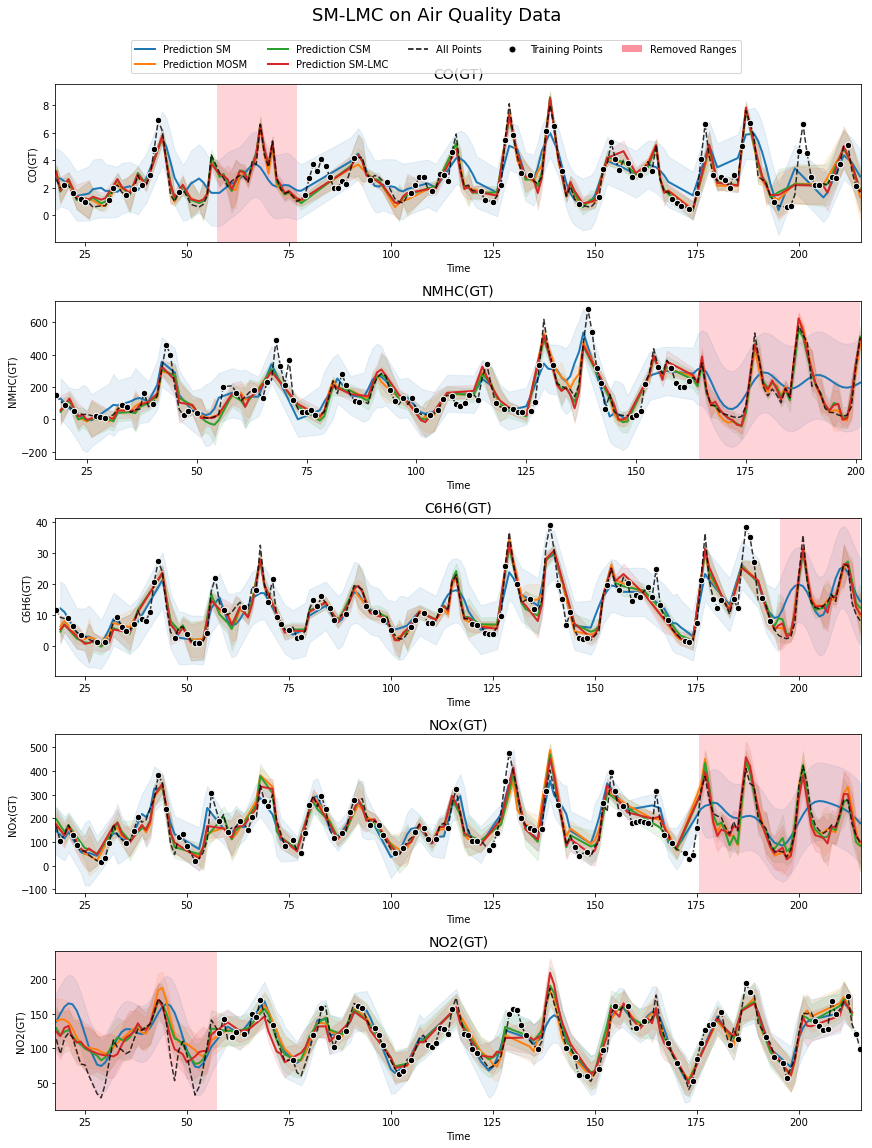

In [10]:
smlmc = mogptk.SM_LMC(dataset, Q=4)
smlmc.init_parameters()
smlmc.train(method='Adam', iters=500, lr=0.5, verbose=True)

smlmc.predict()
dataset.plot(title='SM-LMC on Air Quality Data');

## Convolutional Gaussian (CONV)


Starting optimization using Adam
‣ Model: CONV
‣ Channels: 5
‣ Mixtures: 4
‣ Training points: 402
‣ Parameters: 64
‣ Initial NLL: 1.482

Optimization finished in 0.94 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.840


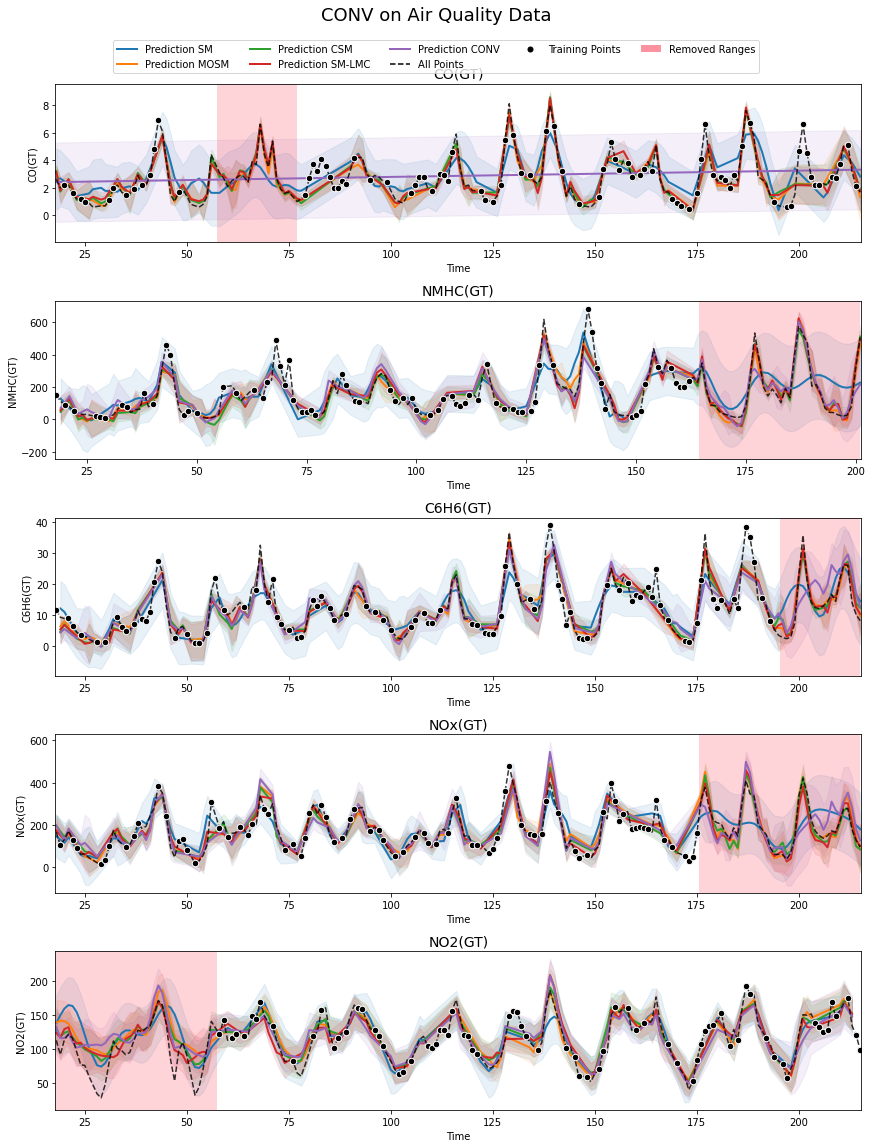

In [11]:
conv = mogptk.CONV(dataset, Q=4)
conv.init_parameters()
conv.train(method='Adam', iters=500, lr=0.1, verbose=True)

conv.predict()
dataset.plot(title='CONV on Air Quality Data');

# Compare errors

We will take the mean MAE, nMAE, RMSE, nRMSE for all the channels and compare all the models.

In [12]:
mogptk.model_error(sm, mosm, csm, smlmc, conv,
                   X=x_test, Y=y_test, disp=True)

,MAE,nMAE,RMSE,nRMSE,MAPE
Name,,,,,
SM channel 0,0.874847,0.115111,1.135842,0.149453,48.195426816851636
SM channel 1,76.579401,0.125335,105.843300,0.173230,104.65148058028018
SM channel 2,3.371040,0.094692,4.782753,0.134347,46.4864195344586
SM channel 3,49.205935,0.123015,65.356623,0.163392,35.197313482049026
SM channel 4,16.971242,0.106737,24.085066,0.151478,20.36849543214299
MOSM channel 0,0.274014,0.036055,0.359601,0.047316,13.727023947553816
MOSM channel 1,29.479164,0.048247,37.676780,0.061664,41.80684972192306
MOSM channel 2,1.415735,0.039768,1.978827,0.055585,16.498568703534605
MOSM channel 3,26.294488,0.065736,34.157791,0.085394,17.19365108436433
